# Лабораторная работа №6: Исследование результатов фильтрации дискретного сигнала с помощью рекурсивных фильтров, построенных на основе формул численного дифференцирования и интегрирования

Выполнили студенты гр. 2384 Кочуров Александр Дмитриевич и Чепасов Дмитрий Витальевич. Вариант №18.


## Цель работы

Получение практических навыков выполнения фильтрации дискретных последовательностей с помощью фильтров, основанных на формулах численного дифференцирования и интегрирования, а также анализа получаемых результатов с помощью дискретного преобразования Фурье (ДПФ). 

## Основные теоретические положения

**Дискретное преобразование Фурье (ДПФ)**:
$$ X(k) = \sum_{n=0}^{N-1} x(n) e^{-j \frac{2\pi}{N} k n}, \quad k = 0, \dots, N-1 $$

**Линейное сглаживание** (по $2m+1$ точкам):
$$ y_n = \frac{1}{2m+1} \sum_{k=-m}^{m} x_{n-k} $$
Частотная характеристика (для 5 точек, $m=2$):
$$ H(\omega) = \frac{1}{5} (1 + 2\cos(\omega) + 2\cos(2\omega)) $$

**Численное дифференцирование** (центральная разность):
$$ y_n = \frac{x_{n+1} - x_{n-1}}{2} $$
Частотная характеристика:
$$ H(\omega) = j \sin(\omega) $$

**Численное интегрирование**:
1. **Метод прямоугольников**: $ y_{n+1} = y_n + x_n $
   $$ H(\omega) = \frac{1}{e^{j\omega} - 1} $$
2. **Метод трапеций**: $ y_{n+1} = y_n + \frac{1}{2}(x_n + x_{n+1}) $
   $$ H(\omega) = \frac{1}{2} \frac{e^{j\omega} + 1}{e^{j\omega} - 1} = \frac{1}{2} \cot(\omega/2) / j $$
3. **Метод Симпсона**: $ y_{n+1} = y_{n-1} + \frac{1}{3}(x_{n-1} + 4x_n + x_{n+1}) $

## Постановка задачи

Для заданного дискретного сигнала применить фильтры, основанные на формулах численного дифференцирования и интегрирования. Полученные результаты содержательно проинтерпретировать.

## Выполнение работы

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Настройка отображения графиков
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['font.size'] = 12

### Пункт 1. Формирование дискретного сигнала

Сформируем сигнал как линейную комбинацию 11 гармоник.
$$ s(t) = \sum_{k=0}^{10} A_k \cos(\omega_k t + \phi_k) $$
где $\omega_k = 0.1 \pi k$.

In [2]:
# Параметры
np.random.seed(42) # Фиксируем seed для воспроизводимости
N = 32 # Количество отсчетов (0..31)
t = np.arange(N) # Дискретное время
t_analog = np.linspace(0, N-1, 1000) # "Аналоговое" время для красивой отрисовки

# Генерация параметров гармоник
num_harmonics = 11
omega = np.array([0.1 * np.pi * k for k in range(num_harmonics)])
A = np.random.randint(1, 12, size=num_harmonics)
A_norm = A / np.sum(A) # Нормализация амплитуд
phi = np.random.uniform(0, 0.5, size=num_harmonics)

# Функция формирования сигнала
def generate_signal(time_points, amps, freqs, phases):
    signal = np.zeros_like(time_points, dtype=float)
    for k in range(len(amps)):
        signal += amps[k] * np.cos(freqs[k] * time_points + phases[k])
    return signal

# Формирование сигналов
x_analog = generate_signal(t_analog, A_norm, omega, phi)
x_discrete = generate_signal(t, A_norm, omega, phi)

print("Амплитуды:", A_norm)
print("Частоты:", omega)

Амплитуды: [0.08333333 0.04761905 0.13095238 0.0952381  0.05952381 0.08333333
 0.11904762 0.03571429 0.08333333 0.13095238 0.13095238]
Частоты: [0.         0.31415927 0.62831853 0.9424778  1.25663706 1.57079633
 1.88495559 2.19911486 2.51327412 2.82743339 3.14159265]


### Пункт 2. Визуализация исходных сигналов

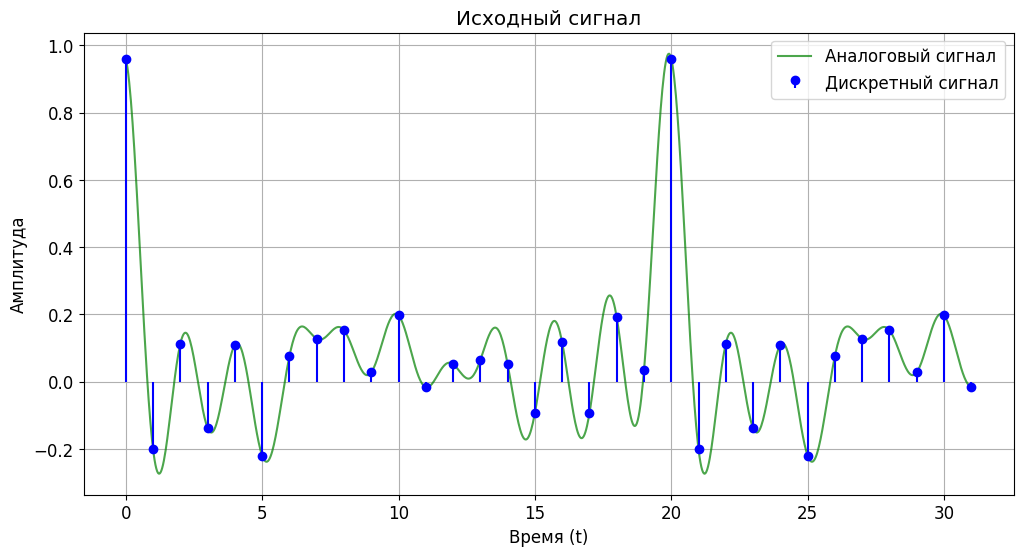

In [3]:
plt.figure()
plt.plot(t_analog, x_analog, 'g-', label='Аналоговый сигнал', alpha=0.7)
plt.stem(t, x_discrete, 'b', markerfmt='bo', basefmt=" ", label='Дискретный сигнал')
plt.title("Исходный сигнал")
plt.xlabel("Время (t)")
plt.ylabel("Амплитуда")
plt.legend()
plt.grid(True)
plt.show()

### Пункт 3. Спектр исходного сигнала (ДПФ)

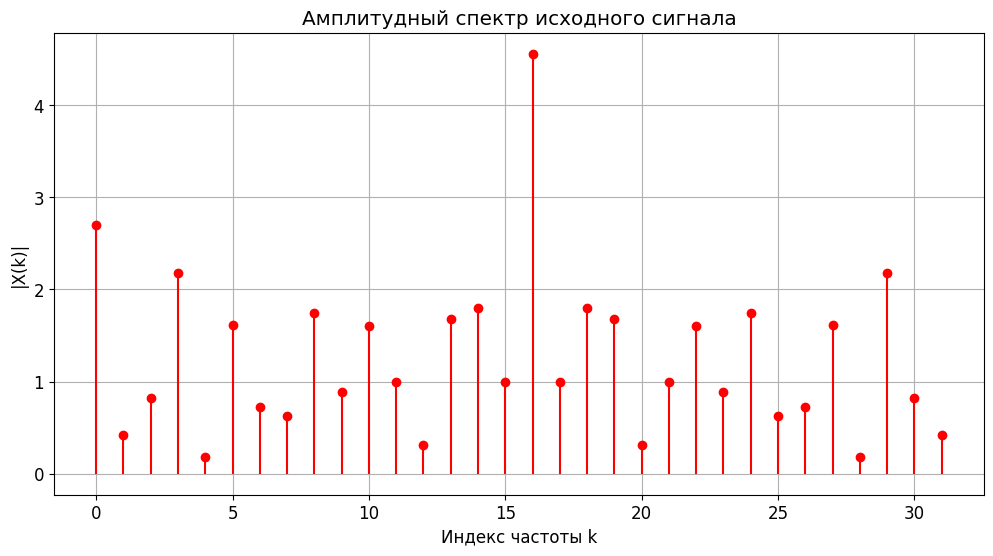

In [4]:
# Вычисление ДПФ
X_spectrum = np.fft.fft(x_discrete)
freqs = np.fft.fftfreq(N)

# Визуализация спектра (амплитуда)
plt.figure()
plt.stem(np.arange(N), np.abs(X_spectrum), 'r', basefmt=" ")
plt.title("Амплитудный спектр исходного сигнала")
plt.xlabel("Индекс частоты k")
plt.ylabel("|X(k)|")
plt.grid(True)
plt.show()

### Пункт 4. Линейное сглаживание

Применим фильтры скользящего среднего по 5 и 9 точкам.

**Теоретические формулы передаточных функций:**

Для 5 точек:
$$ H_5(\omega) = \frac{1}{5} (1 + 2\cos(\omega) + 2\cos(2\omega)) $$

Для 9 точек:
$$ H_9(\omega) = \frac{1}{9} (1 + 2\cos(\omega) + 2\cos(2\omega) + 2\cos(3\omega) + 2\cos(4\omega)) $$

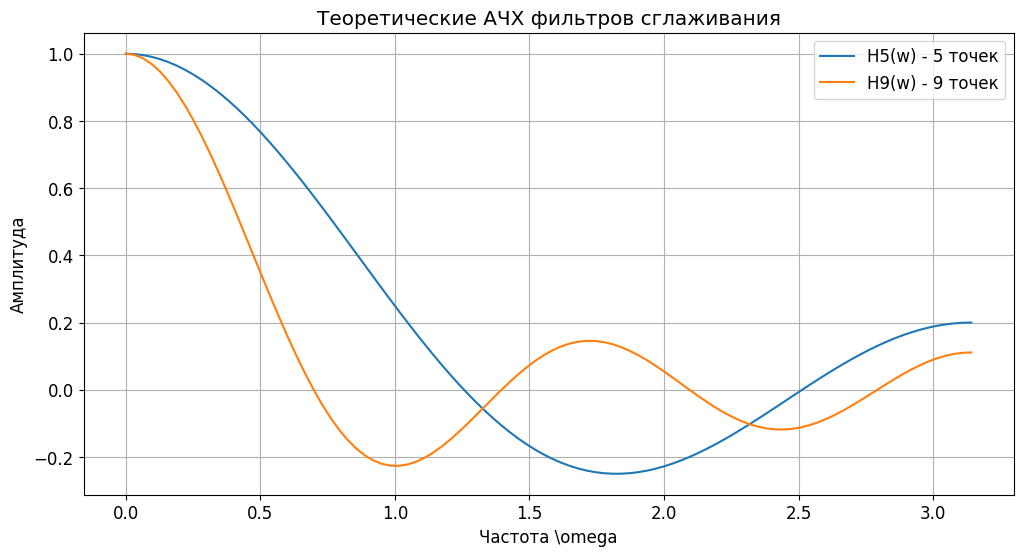

In [5]:
# Функция линейного сглаживания (свертка)
def linear_smooth(signal, window_size):
    kernel = np.ones(window_size) / window_size
    # mode='same' сохраняет размер массива, но на краях могут быть артефакты
    return np.convolve(signal, kernel, mode='same')

# Применение фильтров
y_smooth_5 = linear_smooth(x_discrete, 5)
y_smooth_9 = linear_smooth(x_discrete, 9)

# Передаточные функции (теоретические)
w_vals = np.linspace(0, np.pi, 100)
H5_vals = (1 + 2*np.cos(w_vals) + 2*np.cos(2*w_vals)) / 5
H9_vals = (1 + 2*np.cos(w_vals) + 2*np.cos(2*w_vals) + 2*np.cos(3*w_vals) + 2*np.cos(4*w_vals)) / 9

# Визуализация H(w)
plt.figure()
plt.plot(w_vals, H5_vals, label='H5(w) - 5 точек')
plt.plot(w_vals, H9_vals, label='H9(w) - 9 точек')
plt.title("Теоретические АЧХ фильтров сглаживания")
plt.xlabel("Частота \omega")
plt.ylabel("Амплитуда")
plt.legend()
plt.grid(True)
plt.show()

### Пункты 5-7. Анализ линейного сглаживания

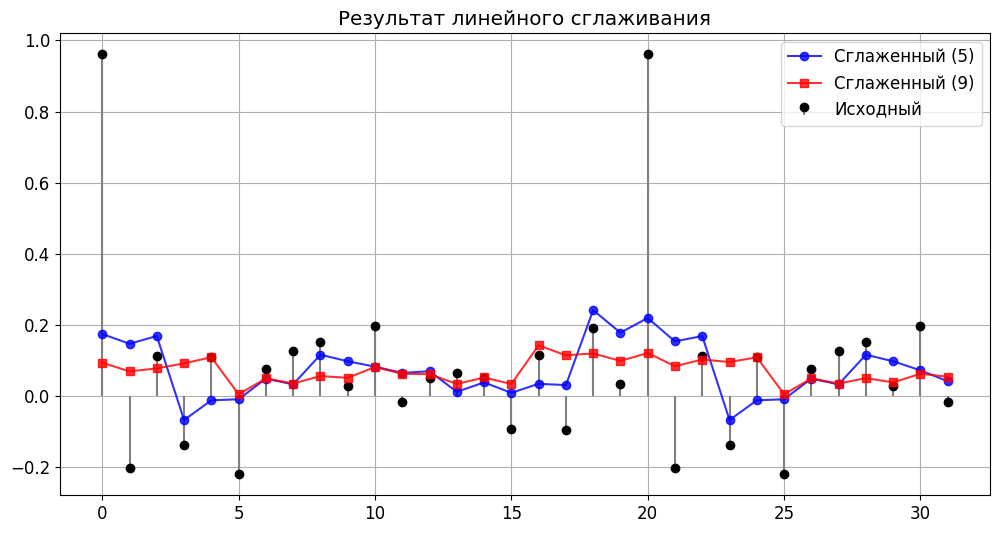

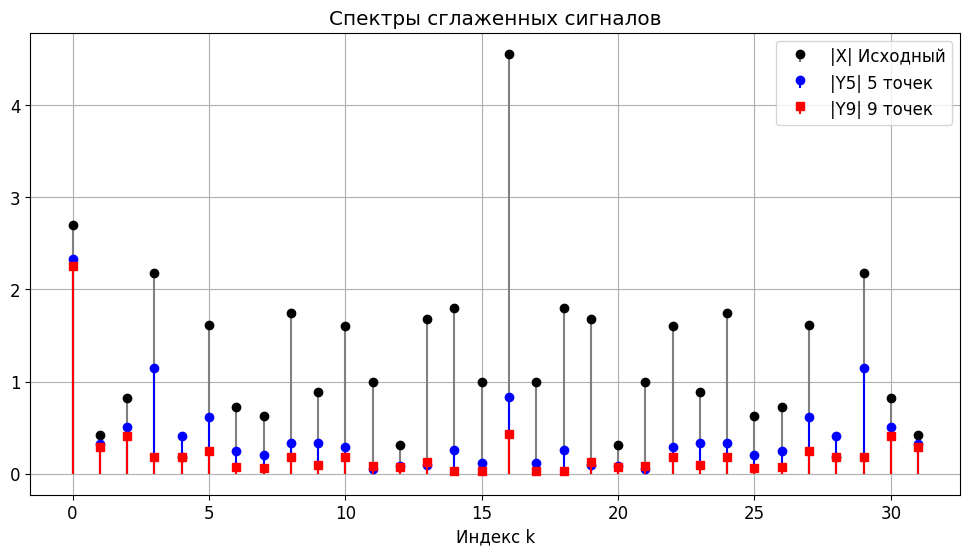

In [6]:
# Визуализация сигналов
plt.figure()
plt.stem(t, x_discrete, 'gray', markerfmt='ko', basefmt=" ", label='Исходный')
plt.plot(t, y_smooth_5, 'b-o', label='Сглаженный (5)', alpha=0.8)
plt.plot(t, y_smooth_9, 'r-s', label='Сглаженный (9)', alpha=0.8)
plt.title("Результат линейного сглаживания")
plt.legend()
plt.grid(True)
plt.show()

# Спектральный анализ
Y5_spec = np.fft.fft(y_smooth_5)
Y9_spec = np.fft.fft(y_smooth_9)

plt.figure()
plt.stem(np.arange(N), np.abs(X_spectrum), 'gray', markerfmt='ko', basefmt=" ", label='|X| Исходный')
plt.stem(np.arange(N), np.abs(Y5_spec), 'b', markerfmt='bo', basefmt=" ", label='|Y5| 5 точек')
plt.stem(np.arange(N), np.abs(Y9_spec), 'r', markerfmt='rs', basefmt=" ", label='|Y9| 9 точек')
plt.title("Спектры сглаженных сигналов")
plt.xlabel("Индекс k")
plt.legend()
plt.grid(True)
plt.show()

**Анализ:**
Фильтры скользящего среднего являются фильтрами низких частот. 
Как видно из графика АЧХ (пункт 4) и спектров (пункт 6), высокочастотные компоненты сигнала подавляются.
Фильтр по 9 точкам имеет более узкую полосу пропускания, поэтому подавляет сигнал сильнее, чем фильтр по 5 точкам, что и наблюдается на графиках (амплитуды спектра для 9 точек ниже).

### Пункт 8. Численное дифференцирование и интегрирование

#### 8a. Дифференцирование 1-го порядка

Формула: $y_n = \frac{x_{n+1} - x_{n-1}}{2}$. (Первый и последний элементы теряются или требуют особого подхода, заменим нулями).

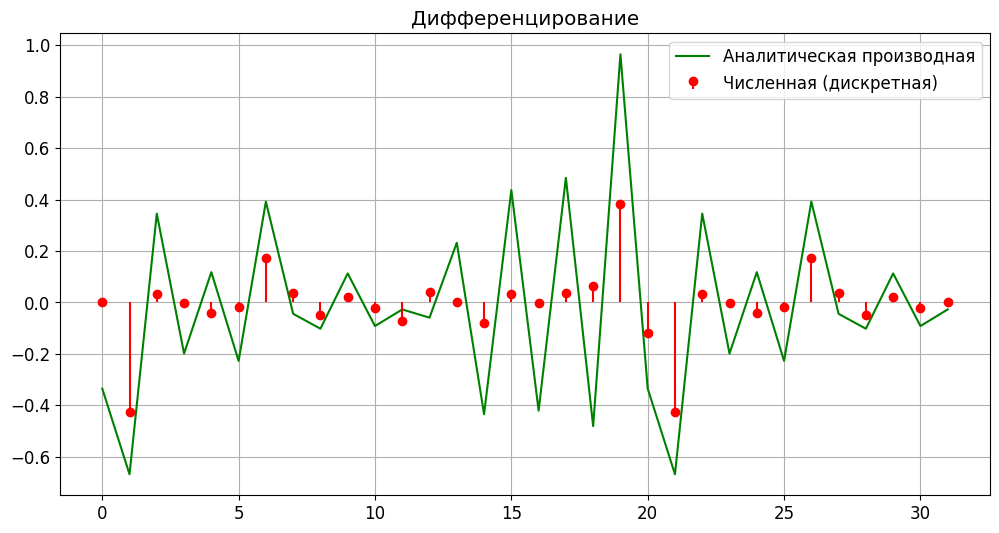

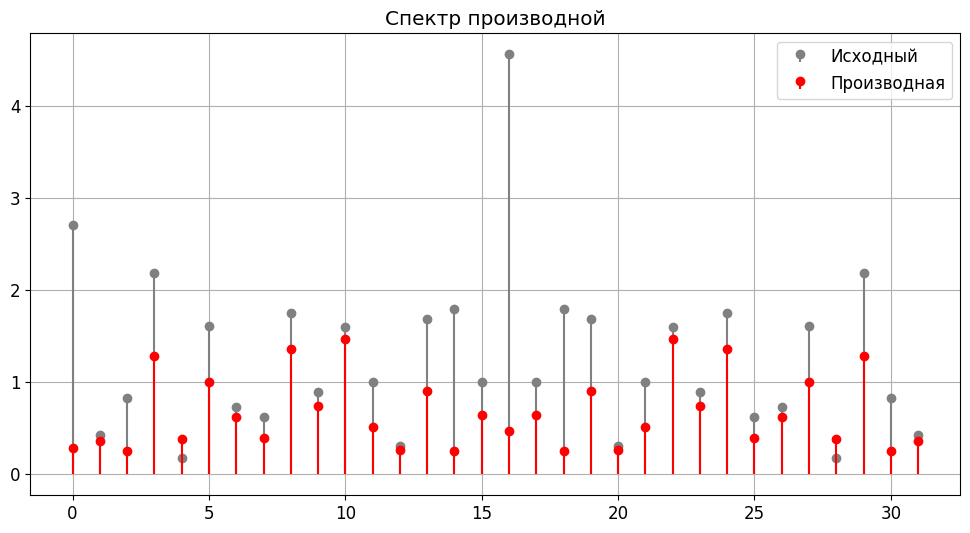

In [7]:
# Аналитическая производная для сравнения
def true_derivative(time_points, amps, freqs, phases):
    res = np.zeros_like(time_points, dtype=float)
    for k in range(len(amps)):
        # d/dt (cos(wt+phi)) = -w * sin(wt+phi)
        res += -amps[k] * freqs[k] * np.sin(freqs[k] * time_points + phases[k])
    return res

x_deriv_true = true_derivative(t, A_norm, omega, phi)

# Численное дифференцирование
y_diff = np.zeros_like(x_discrete)
# Центральная разность для внутренних точек
y_diff[1:-1] = (x_discrete[2:] - x_discrete[:-2]) / 2

# Графики
plt.figure()
plt.plot(t, x_deriv_true, 'g-', label='Аналитическая производная')
plt.stem(t, y_diff, 'r', markerfmt='ro', basefmt=" ", label='Численная (дискретная)')
plt.title("Дифференцирование")
plt.legend()
plt.grid(True)
plt.show()

# Спектр
Y_diff_spec = np.fft.fft(y_diff)
plt.figure()
plt.stem(np.arange(N), np.abs(X_spectrum), 'gray', label='Исходный', basefmt=" ")
plt.stem(np.arange(N), np.abs(Y_diff_spec), 'r', label='Производная', basefmt=" ")
plt.title("Спектр производной")
plt.legend()
plt.grid(True)
plt.show()

**Анализ дифференцирования:**
Операция дифференцирования в частотной области соответствует умножению на $j\omega$ (для непрерывного) или $j \sin(\omega)$ (для данной дискретной формулы). Это означает усиление высоких частот и подавление постоянной составляющей (нулевой частоты). На спектре видно, что низкочастотные компоненты (k около 0) подавлены, а более высокие частоты относительно усилены по сравнению с исходным сигналом.

#### 8b. Численное интегрирование

Реализуем три метода рекурсивно.

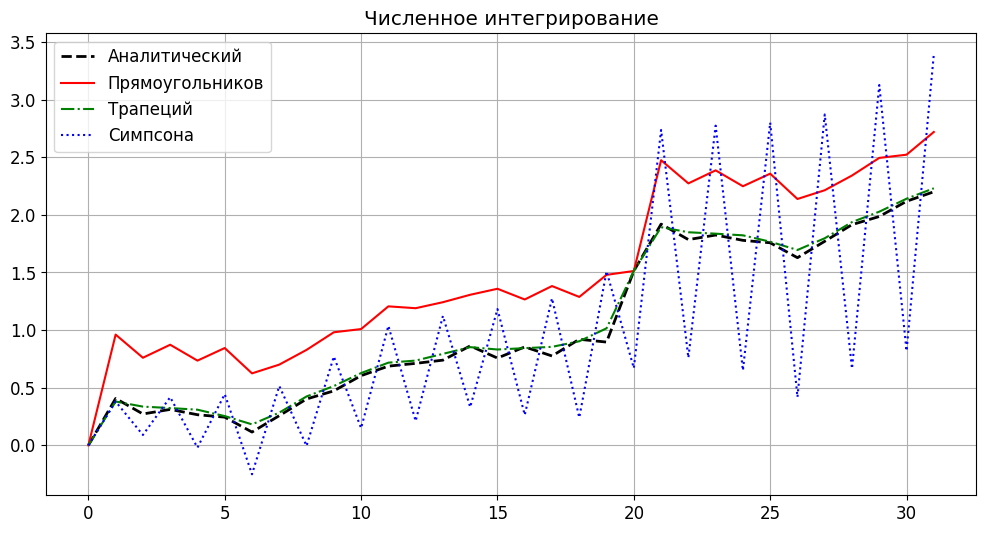

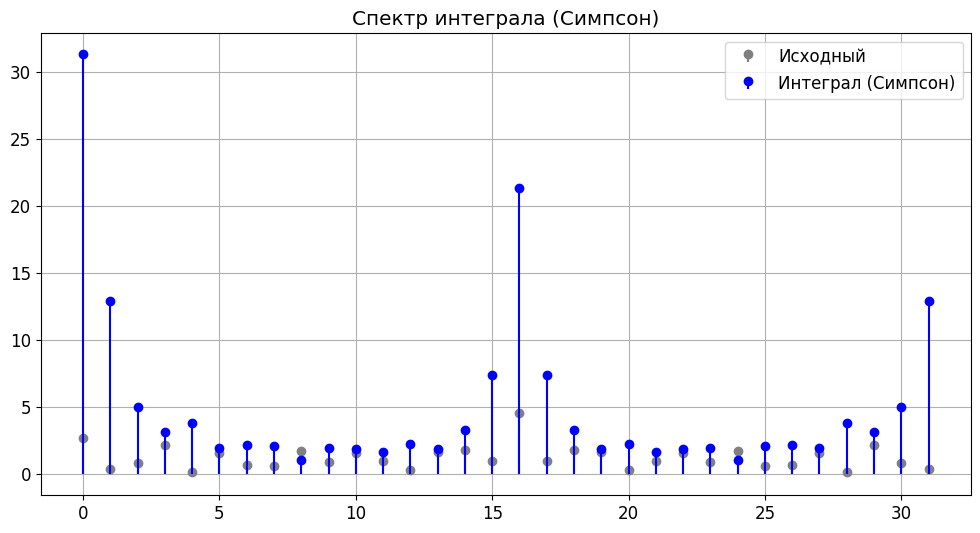

In [8]:
# Аналитический интеграл (неопределенный, с константой 0 для простоты)
def true_integral(time_points, amps, freqs, phases):
    res = np.zeros_like(time_points, dtype=float)
    for k in range(len(amps)):
        if freqs[k] != 0:
            # int cos(wt+phi) = 1/w * sin(wt+phi)
            res += (amps[k] / freqs[k]) * np.sin(freqs[k] * time_points + phases[k])
        else:
            res += amps[k] * time_points * np.cos(phases[k]) # Линейный тренд для DC
    return res

x_int_true = true_integral(t, A_norm, omega, phi)
# Сдвинем аналитический интеграл, чтобы он начинался примерно там же, где и численные (условно)
x_int_true -= x_int_true[0]


# 1. Метод прямоугольников: y[n] = y[n-1] + x[n-1] (кумулятивная сумма)
y_rect = np.zeros_like(x_discrete)
for n in range(1, N):
    y_rect[n] = y_rect[n-1] + x_discrete[n-1]

# 2. Метод трапеций: y[n] = y[n-1] + 0.5 * (x[n] + x[n-1])
y_trap = np.zeros_like(x_discrete)
for n in range(1, N):
    y_trap[n] = y_trap[n-1] + 0.5 * (x_discrete[n] + x_discrete[n-1])

# 3. Метод Симпсона: y[n] = y[n-2] + 1/3 * (x[n-2] + 4*x[n-1] + x[n])
y_simp = np.zeros_like(x_discrete)
# Первую точку для Симпсона возьмем из трапеций, т.к. рекурсия требует n-2
y_simp[1] = y_trap[1]
for n in range(2, N):
    y_simp[n] = y_simp[n-2] + (1/3) * (x_discrete[n-2] + 4*x_discrete[n-1] + x_discrete[n])


# Графики
plt.figure()
plt.plot(t, x_int_true, 'k--', label='Аналитический', linewidth=2)
plt.plot(t, y_rect, 'r-', label='Прямоугольников')
plt.plot(t, y_trap, 'g-.', label='Трапеций')
plt.plot(t, y_simp, 'b:', label='Симпсона')
plt.title("Численное интегрирование")
plt.legend()
plt.grid(True)
plt.show()

# Спектры (возьмем метод Симпсона для примера)
Y_int_spec = np.fft.fft(y_simp)
plt.figure()
plt.stem(np.arange(N), np.abs(X_spectrum), 'gray', label='Исходный', basefmt=" ")
plt.stem(np.arange(N), np.abs(Y_int_spec), 'b', label='Интеграл (Симпсон)', basefmt=" ")
plt.title("Спектр интеграла (Симпсон)")
plt.legend()
plt.grid(True)
plt.show()

**Анализ интегрирования:**
Интегрирование — это фильтр нижних частот (спектральная плотность делится на частоту $\approx 1/\omega$).
На графике спектра видно значительное усиление низкочастотных компонент (особенно постоянной составляющей и первой гармоники) и подавление высоких частот, что соответствует теоретическому поведению интегратора ($H(0) \to \infty$).
Метод Симпсона обычно дает более точное приближение к аналитическому интегралу для гладких функций, однако все методы демонстрируют накопление ошибки (дрейф), если в сигнале есть постоянная составляющая или низкочастотный шум.

## Выводы

В ходе лабораторной работы были исследованы различные цифровые фильтры.
1. **Сглаживающие фильтры** (скользящее среднее) эффективно подавляют высокочастотный шум, причем эффективность подавления растет с увеличением порядка фильтра (длины окна).
2. **Дифференцирующий фильтр** подчеркивает высокочастотные изменения сигнала (перепады), работая как фильтр верхних частот, и подавляет постоянную составляющую.
3. **Интегрирующие фильтры** работают как фильтры нижних частот, сглаживая сигнал, но склонны к накоплению тренда при наличии постоянной составляющей на входе.

Анализ с помощью ДПФ подтвердил теоретические предположения о частотных свойствах исследованных алгоритмов.